In [ ]:
# Solutions

# 1. Adding more data
# 2. Reducing the complexity of the NN arichiteture
# 3. Regularization
# 4. Dropouts
# 5. Data Augumentation
# 6. Batch Normalization
# 7. Early Stopping

# Dropouts

In [ ]:
# 1. Applied to the hidden layers
# 2. Applied after the relu and activation function
# 3. Randomly turns offf p% neurons in the hidden layer during each forward pass
# 4. This has a regularaization effect
# 5. During Evl dropout is not used

In [ ]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d zalando-research/fashionmnist

Dataset URL: https://www.kaggle.com/datasets/zalando-research/fashionmnist
License(s): other
  0% 0.00/68.8M [00:00<?, ?B/s]
100% 68.8M/68.8M [00:00<00:00, 1.70GB/s]


In [ ]:
!unzip -q fashionmnist.zip -d ./data


In [ ]:
!ls ./data

fashion-mnist_test.csv	 t10k-images-idx3-ubyte  train-images-idx3-ubyte
fashion-mnist_train.csv  t10k-labels-idx1-ubyte  train-labels-idx1-ubyte


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset,DataLoader
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [ ]:
# Set the random seeds for reproducibility
torch.manual_seed(42)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using Device : ",device)

Using Device :  cuda


In [ ]:
df = pd.read_csv("./data/fashion-mnist_train.csv")
df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


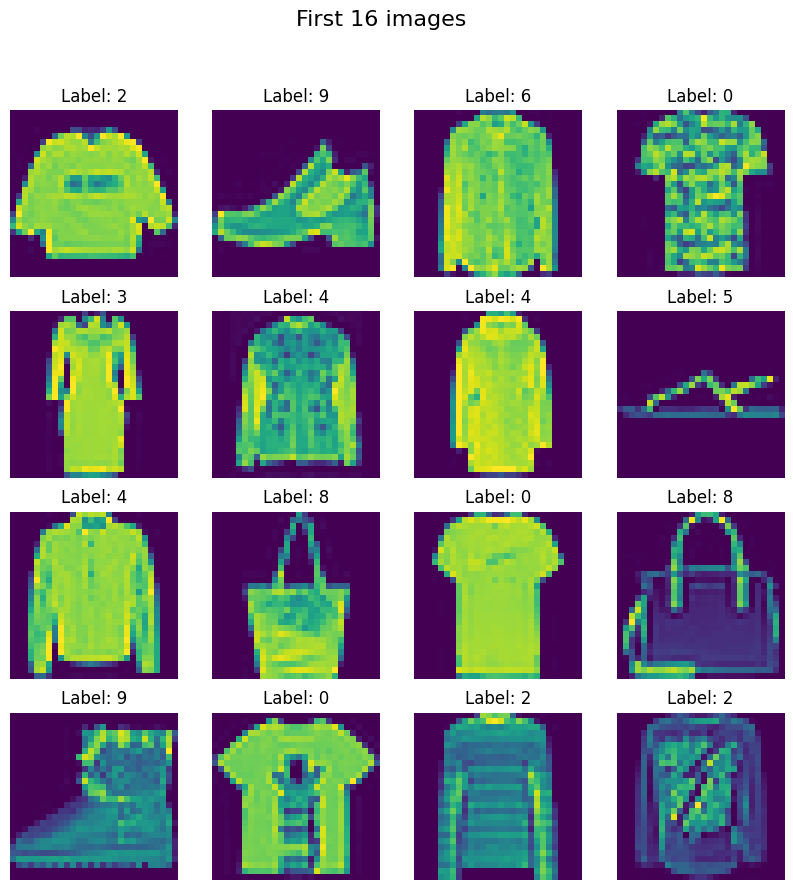

In [ ]:
fig,axes = plt.subplots(4,4,figsize=(10,10))
fig.suptitle("First 16 images ",fontsize=16)

for i ,ax in enumerate(axes.flat):
    img = df.iloc[i,1:].values.reshape(28,28)
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(f"Label: {df.iloc[i,0]}")

In [ ]:
x = df.iloc[:,1:].values
y = df.iloc[:,0].values

In [ ]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=42)

In [ ]:
## Scaling featurs
x_train = x_train/255.0
x_test = x_test/255.0

In [ ]:
# Create the custome class
class CustomeDataset(Dataset):
    def __init__(self,featurs,lables):
        self.featurs = torch.tensor(featurs,dtype=torch.float32)
        self.lable = torch.tensor(lables,dtype=torch.long)

    def __len__(self):
        return len(self.featurs)

    def __getitem__(self, index):
        return self.featurs[index],self.lable[index]

In [ ]:
# Create the train dataset object
train_dataset = CustomeDataset(x_train,y_train)

In [ ]:
len(train_dataset)

48000

In [ ]:
# Create the test dataset object
test_dataset = CustomeDataset(x_test,y_test)
len(test_dataset)

12000

In [ ]:
# Create the Train and test loader

train_loader = DataLoader(train_dataset,batch_size=32,shuffle=True)

test_loader = DataLoader(test_dataset,batch_size=32,shuffle=False)

In [ ]:
# Define NN class
class MyNN(nn.Module):
    def __init__(self,num_featurs):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(num_featurs,128),

            # Batch Normlaization
            nn.BatchNorm1d(128),

            nn.ReLU(),

            # Dropout
            nn.Dropout(0.2),
            nn.Linear(128,64),

            # Batch Norm
            nn.BatchNorm1d(64),

            nn.ReLU(),

            # Dropout
            nn.Dropout(0.2),
            nn.Linear(64,10)
        )

    def forward(self,x):
        return self.model(x)


In [ ]:
# set learning and epochs
epochs = 50
learning_rate =0.1


In [ ]:
# Instatiate the model
model = MyNN(x_train.shape[1])
model = model.to(device)

# loss function
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = optim.SGD(model.parameters(),lr=learning_rate,weight_decay=1e-4)


In [ ]:
# Training Loop
for epoch in range(epochs):
    total_epoch_loss = 0
    for batch_featurs , batch_lables in train_loader:

        # move to GPU
        batch_featurs = batch_featurs.to(device)
        batch_lables = batch_lables.to(device)

        # forward pass
        y_pred = model.forward(batch_featurs)

        # loss calculate
        loss = criterion(y_pred,batch_lables)

        # Backprop
        optimizer.zero_grad()
        loss.backward()

        # Update the gradients
        optimizer.step()

        total_epoch_loss = total_epoch_loss + loss.item()
    avg_loss = total_epoch_loss/len(train_loader)
    print(f"Epoch : {epoch +1 } Loss : {avg_loss}")

Epoch : 1 Loss : 0.5790093433956305
Epoch : 2 Loss : 0.45404486179351805
Epoch : 3 Loss : 0.4146016920357943
Epoch : 4 Loss : 0.3908622784713904
Epoch : 5 Loss : 0.3763451832930247
Epoch : 6 Loss : 0.3665035707106193
Epoch : 7 Loss : 0.3530690363695224
Epoch : 8 Loss : 0.3467472512672345
Epoch : 9 Loss : 0.33324655205011366
Epoch : 10 Loss : 0.3265992530733347
Epoch : 11 Loss : 0.3220274396215876
Epoch : 12 Loss : 0.3157223462065061
Epoch : 13 Loss : 0.31108853182196616
Epoch : 14 Loss : 0.3055510268881917
Epoch : 15 Loss : 0.3002403910557429
Epoch : 16 Loss : 0.29460327412188053
Epoch : 17 Loss : 0.2933059433052937
Epoch : 18 Loss : 0.2889194576938947
Epoch : 19 Loss : 0.28526972416291635
Epoch : 20 Loss : 0.28525599487622577
Epoch : 21 Loss : 0.2818351363092661
Epoch : 22 Loss : 0.2768779086222251
Epoch : 23 Loss : 0.27704834286371866
Epoch : 24 Loss : 0.27222149123748146
Epoch : 25 Loss : 0.2710339842066169
Epoch : 26 Loss : 0.27141732825587195
Epoch : 27 Loss : 0.2647932243471344
E

In [ ]:
# Set the model to eval model
model.eval()

MyNN(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.2, inplace=False)
    (8): Linear(in_features=64, out_features=10, bias=True)
  )
)

In [ ]:
# Evaulation code
total = 0
correct = 0

with torch.no_grad():
    for batch_featurs,batch_lables in train_loader:
        # move to GPU
        batch_featurs = batch_featurs.to(device)
        batch_lables = batch_lables.to(device)
        output = model(batch_featurs)
        _,predicted = torch.max(output,1)

        total = total + batch_lables.shape[0]
        correct = correct + (predicted == batch_lables).sum().item()

    print(correct/total)



In [ ]:
# Evaulation code
total = 0
correct = 0

with torch.no_grad():
    for batch_featurs,batch_lables in test_loader:
        # move to GPU
        batch_featurs = batch_featurs.to(device)
        batch_lables = batch_lables.to(device)
        output = model(batch_featurs)
        _,predicted = torch.max(output,1)

        total = total + batch_lables.shape[0]
        correct = correct + (predicted == batch_lables).sum().item()

    print(correct/total)



0.8911666666666667


In [ ]:
# Improve accuracy

# Use the whole dataset
# optimizers
# learning rate
# epochs
# weights init
# regularization
# dropoput
# batch norm

# model architecutre
